Using TF LSTM with a Sequential Model Predict a time window of a stock

In [23]:
#Import the libraries
import math
# import pandas_datareader as web
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM # Long Short-Term Memory layer
import keras
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from timeit import default_timer as timer

plt.style.use('fivethirtyeight')

sample_start_date = (datetime.now() - timedelta(days=280)).strftime("%Y-%m-01") 
sample_stop_date = datetime.now().strftime("%Y-%m-%d") 
print("{} -> {}".format(sample_start_date, sample_stop_date))
# STOCK='CPRX'
STOCK='AMD'
# STOCK='NCLH'
# STOCK='ISEE'
# STOCK='GME'

# STOCK='LCID'
# STOCK='TLRY'
#STOCK='NKLA'

n_days_to_trend=45

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(np.sqrt(-results['mean_test_score'][candidate]),
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)
        
def get_stock_data(stock, sample_start_date, sample_stop_date):
    # web reader no longer works 
    # df = web.DataReader(STOCK, data_source='yahoo', start=sample_start_date, end=sample_stop_date) 

    df = yf.download(stock, start=sample_start_date, end=sample_stop_date)
    return df


2023-10-01 -> 2024-07-22


In [24]:
#Get the stock quote 
df = get_stock_data(STOCK, sample_start_date=sample_start_date, sample_stop_date=sample_stop_date)

print(df)

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-10-02  102.209999  103.709999  101.699997  103.269997  103.269997   
2023-10-03  101.800003  103.290001   99.169998  100.080002  100.080002   
2023-10-04  100.650002  104.400002  100.339996  104.070000  104.070000   
2023-10-05  103.410004  103.739998  100.269997  102.910004  102.910004   
2023-10-06  102.160004  107.870003  102.029999  107.239998  107.239998   
...                ...         ...         ...         ...         ...   
2024-07-15  184.449997  185.500000  178.539993  179.830002  179.830002   
2024-07-16  179.690002  179.750000  174.529999  177.550003  177.550003   
2024-07-17  169.800003  169.800003  159.369995  159.429993  159.429993   
2024-07-18  163.410004  163.410004  153.199997  155.770004  155.770004   
2024-07-19  154.860001  155.809998  150.619995  151.580002  151.580002   

              Volume  
Date          

In [25]:
df.shape

(201, 6)

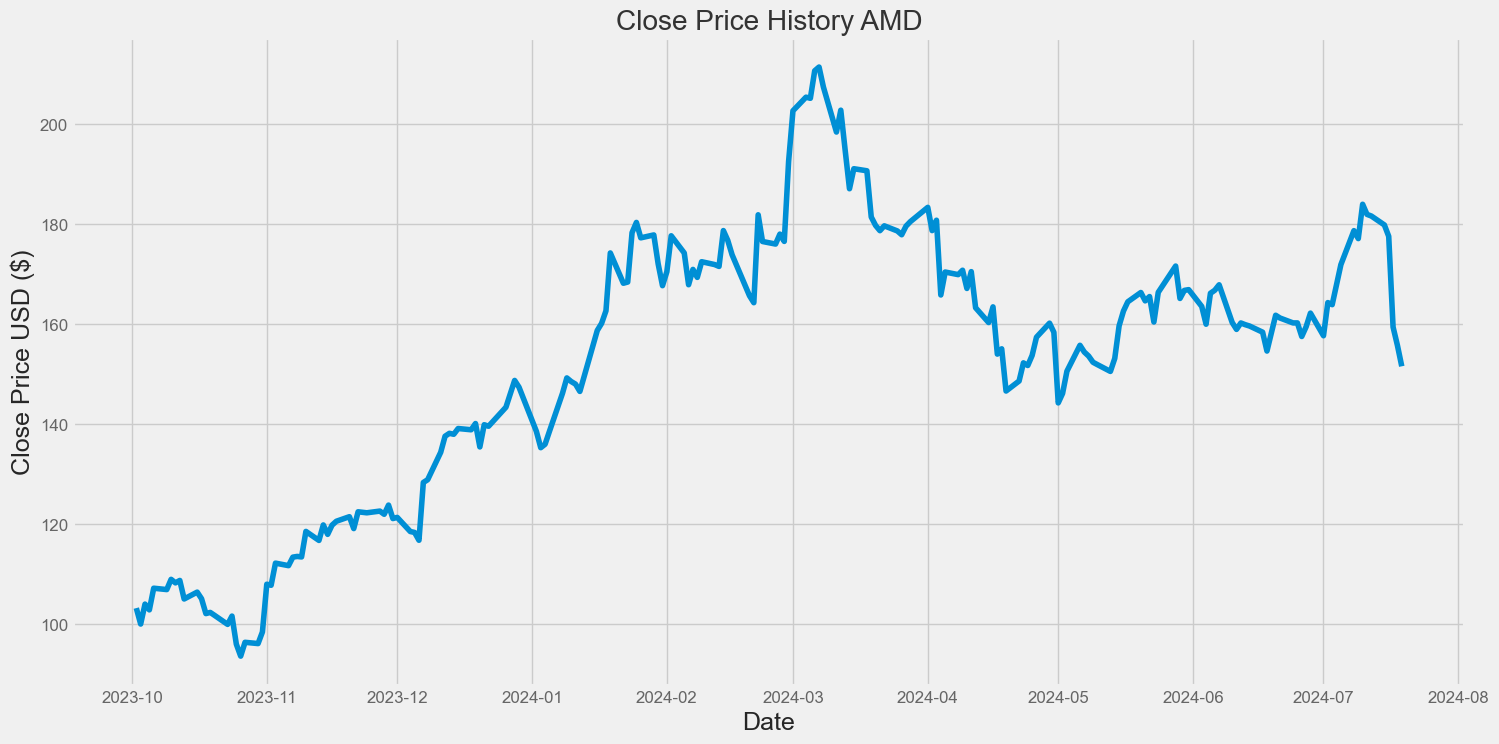

In [26]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History {}'.format(STOCK))
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [27]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
# print(data)
#Converting the dataframe to a numpy array
dataset = data.values
print(len(dataset))
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

201


In [28]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)
# print(scaled_data)

In [29]:
#Create the scaled training data set 
print(training_data_len)
train_data = scaled_data[0:training_data_len, : ]
print(len(train_data))
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(n_days_to_trend,len(train_data)):
    x_train.append(train_data[i-n_days_to_trend:i,0])
    y_train.append(train_data[i,0])
print(len(x_train))
print(len(y_train))

161
161
116
116


In [30]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [31]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [32]:
# we wil be using a Sequential model, with 4 alayers

model = Sequential()
model.add(LSTM(units=113, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))


#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display a model summary
model.summary()

# model.save('my_stock_model.h5')
model.save('my_model.keras')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 45, 113)           51980     
                                                                 
 lstm_3 (LSTM)               (None, 50)                32800     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 86,081
Trainable params: 86,081
Non-trainable params: 0
_________________________________________________________________


In [33]:
#Train the model
cb = TimingCallback()
model.fit(x_train, y_train, batch_size=1, epochs=25, workers=1, callbacks=[cb])
# print(cb.logs)
print("{} Seconds".format(sum(cb.logs)))

Epoch 1/25
116/116 [==============================] - 1s 6ms/step - loss: 0.0183
Epoch 2/25
116/116 [==============================] - 1s 5ms/step - loss: 0.0123
Epoch 3/25
116/116 [==============================] - 1s 7ms/step - loss: 0.0100
Epoch 4/25
116/116 [==============================] - 1s 6ms/step - loss: 0.0062
Epoch 5/25
116/116 [==============================] - 1s 6ms/step - loss: 0.0063
Epoch 6/25
116/116 [==============================] - 1s 6ms/step - loss: 0.0044
Epoch 7/25
116/116 [==============================] - 1s 5ms/step - loss: 0.0049
Epoch 8/25
116/116 [==============================] - 1s 5ms/step - loss: 0.0052
Epoch 9/25
116/116 [==============================] - 1s 6ms/step - loss: 0.0041
Epoch 10/25
116/116 [==============================] - 1s 5ms/step - loss: 0.0046
Epoch 11/25
116/116 [==============================] - 1s 6ms/step - loss: 0.0039
Epoch 12/25
116/116 [==============================] - 1s 6ms/step - loss: 0.0034
Epoch 13/25
116/116 [====

In [34]:
#Test data set
test_data = scaled_data[training_data_len - n_days_to_trend: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(n_days_to_trend,len(test_data)):
    x_test.append(test_data[i-n_days_to_trend:i,0])
    

In [35]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [36]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [37]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

2/2 [==============================] - 0s 5ms/step


In [38]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions - y_test)**2)))
rmse

4.8215081031927465

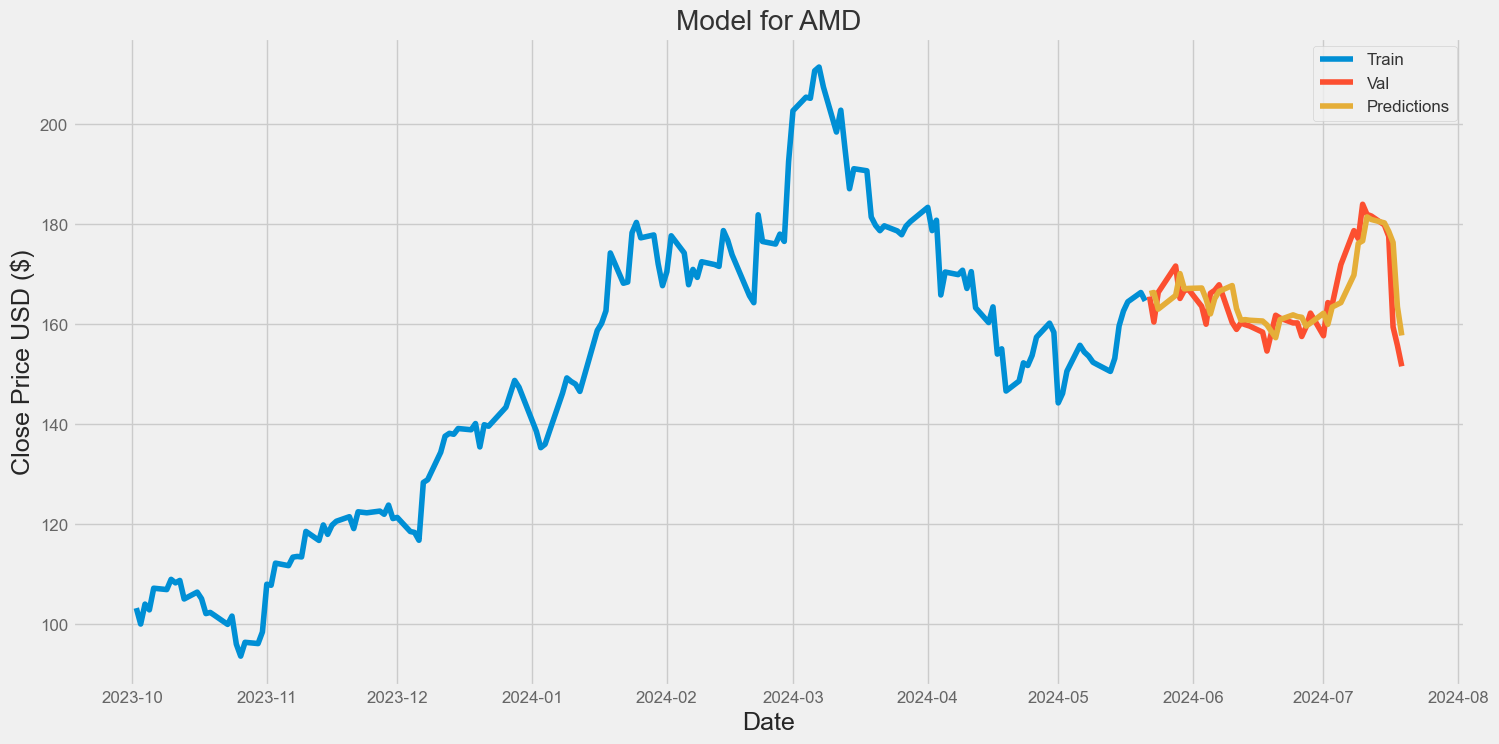

In [39]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
# print(valid['Close'])
# valid['Predictions'] = predictions
valid.insert(1, "Predictions", predictions, True) 
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model for {}'.format(STOCK))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
# plt.show()